In [1]:
from model import atp_graph, losses
from Tutorials.helper import batcher
from data import synthetic_data_gen, feature_extractor
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import tensorflow as tf
import IPython
import time
import os

from model import atp_pipeline

In [2]:
from data import dataset_preparer

#dataset - [weather,traffic,...]

#hyperparams - num_heads,...

In [ ]:
####

#electricity

# make batcher as a function of n_C and n_T - window

## other NP experiments

# test on n_C and n_T which are randomly selected at each point - outside batcher 

# don't repeat testing points  

# for NP experiments, we need to batch differently. for forecasting 100000 x1 ---> 32 x 288 x 1.
# for np, we will have 10000 x 288 x 1 -> 32 x 288 x 1

#also divide mse by n_T each batch for testing

In [ ]:
### set this up for training and saving best models adn then loading it and calculating loglik.

## start here

In [1]:
from model import atp_graph, losses
from data import synthetic_data_gen, feature_extractor
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline
from data import dataset_preparer
import argparse
from Tutorials.helper import batcher
import os

In [2]:
x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.weather_processor(path_to_weather_data="datasets/weather.csv") 
save_dir = "weights/forecasting/weather"
    

In [3]:
n_C = 100
n_T = 100

opt = tf.keras.optimizers.Adam(3e-4)
batch_size = 32

In [5]:
step = 1
run= 52 + 0
tf.random.set_seed(run)
atp_model = atp_pipeline.instantiate_atp("weather")
tr_step = atp_graph.build_graph()
name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp
if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 
sum_mse_tot = 0; sum_nll_tot = 0
mini = 50000

for i in range(1):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not weather
    _,_, _, _ = tr_step(atp_model, opt, x,y,n_C,n_T, training=True)

#     if i % 1 == 0:
#         idx_list = list(range(x_val.shape[0]- (n_C+n_T)))
#         t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
#         μ, log_σ = atp_model([t_te, y_te, n_C, n_T, False])
#         _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)

#         if nll_pp_te < mini:
#             mini = nll_pp_te
#             manager.save()
#             step += 1
#             ckpt.step.assign_add(1)

2023-05-03 16:11:45.620480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-03 16:11:45.620747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Tensor("Const_2:0", shape=(), dtype=bool)
Tensor("Const_2:0", shape=(), dtype=bool)


2023-05-03 16:11:48.276554: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-03 16:11:48.277102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
manager.save()
step += 1
ckpt.step.assign_add(1)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=2>

In [7]:
μ, log_σ = atp_model([x,y, n_C, n_T, False])

tf.Tensor(False, shape=(), dtype=bool)


In [21]:
tf.random.set_seed(run)

In [22]:
atp_model_test = atp_pipeline.instantiate_atp("weather")

In [23]:
# name_comp = 'run_' + str(run)
# folder = save_dir + '/ckpt/check_' + name_comp
# if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model_test)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 


In [24]:
μ_test_2, log_σ_test_2 = atp_model_test([x,y, n_C, n_T, False])

tf.Tensor(False, shape=(), dtype=bool)


In [26]:
np.all(μ_test.numpy() == μ.numpy())

True

In [27]:
for i, w in enumerate(atp_model.weights):
    print(np.all(w.numpy() == atp_model_test.weights[i].numpy()))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## Training

In [5]:
import matplotlib.pyplot as plt

In [26]:
train_loglik = []
val_loglik = []



In [27]:
step = 1
run= 50 + 0
tf.random.set_seed(run)
atp_model = atp_pipeline.instantiate_atp("weather")
tr_step = atp_graph.build_graph()
name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp
if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 
sum_mse_tot = 0; sum_nll_tot = 0
mini = 50000
opt = tf.keras.optimizers.Adam(3e-4)


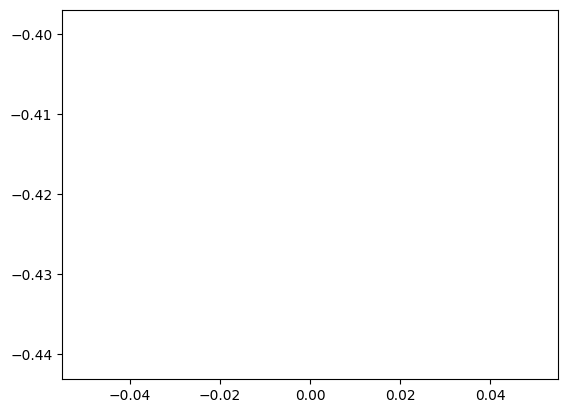

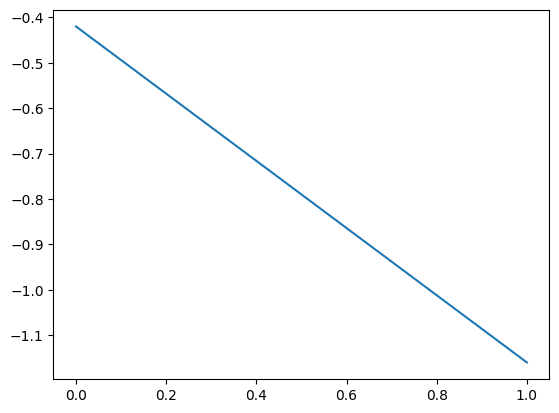

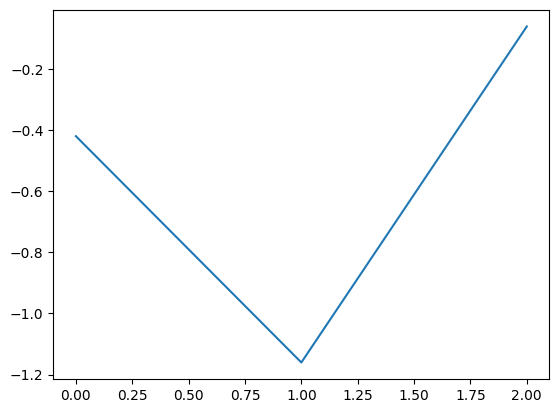

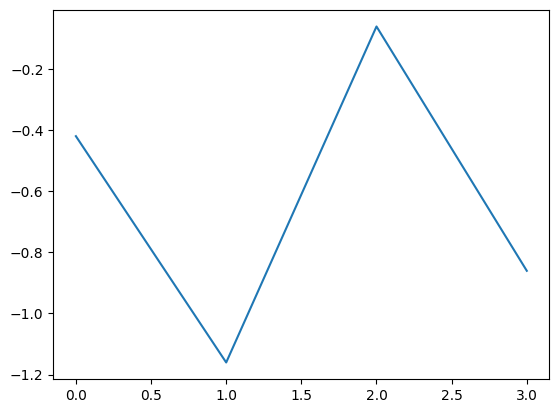

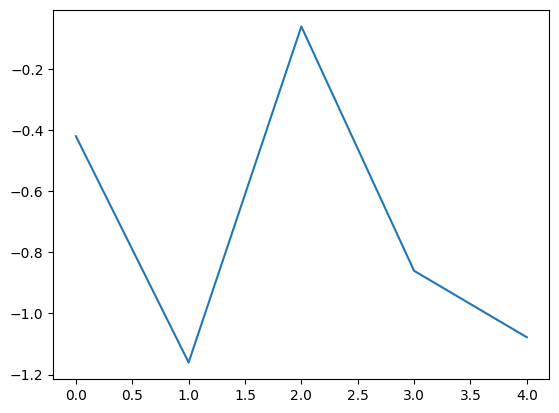

CPU times: user 29.6 s, sys: 2.21 s, total: 31.9 s
Wall time: 52.4 s


In [28]:
%%time

for i in range(500):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not weather
    _,_, nll_pp_tr , _ = tr_step(atp_model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        
        train_loglik.append(nll_pp_tr)
        
        
#         idx_list = list(range(x_val.shape[0]- (n_C+n_T)))
#         t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
#         μ, log_σ = atp_model([t_te, y_te, n_C, n_T, False])
#         _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        
#         val_loglik.append(nll_pp_te)
        
        plt.plot(train_loglik)
#         plt.plot(val_loglik)
        plt.show()

In [14]:
y_train.shape

(36887, 1, 1)

In [15]:
y.shape

(32, 200, 1)

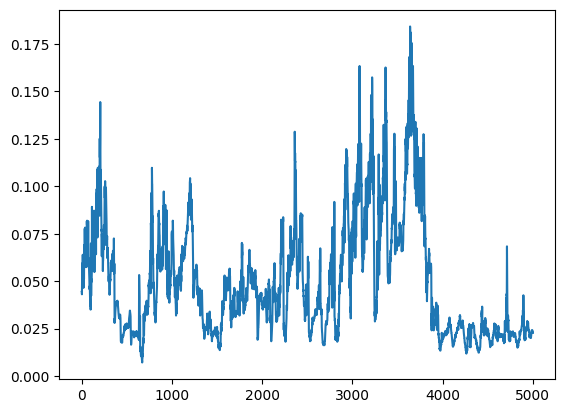

In [27]:
plt.plot(y_train[:5000,0,0])
# plt.ylim([-0.25,0.25])

In [ ]:
def weather_processor(path_to_weather_data):

        pd_array = pd.read_csv(path_to_weather_data)
        data = np.array(pd_array)
        data[:,0] = np.linspace(-1,1,data.shape[0])
        data = data.astype("float32")

       

In [28]:
pd_array = pd.read_csv("datasets/weather.csv")
data = np.array(pd_array)

In [32]:
pd_array.iloc[2]

date                    2020-01-01 00:30:00
p (mbar)                            1008.66
T (degC)                               0.73
Tpot (K)                             273.21
Tdew (degC)                           -1.48
rh (%)                                 85.1
VPmax (mbar)                           6.44
VPact (mbar)                           5.48
VPdef (mbar)                           0.96
sh (g/kg)                              3.39
H2OC (mmol/mol)                        5.43
rho (g/m**3)                        1280.29
wv (m/s)                               0.61
max. wv (m/s)                          1.48
wd (deg)                              197.1
rain (mm)                               0.0
raining (s)                             0.0
SWDR (W/m�)                             0.0
PAR (�mol/m�/s)                         0.0
max. PAR (�mol/m�/s)                    0.0
Tlog (degC)                            11.6
OT                                    427.6
Name: 2, dtype: object

In [38]:
np.astype(data[:,4],"float32")

AttributeError: module 'numpy' has no attribute 'astype'

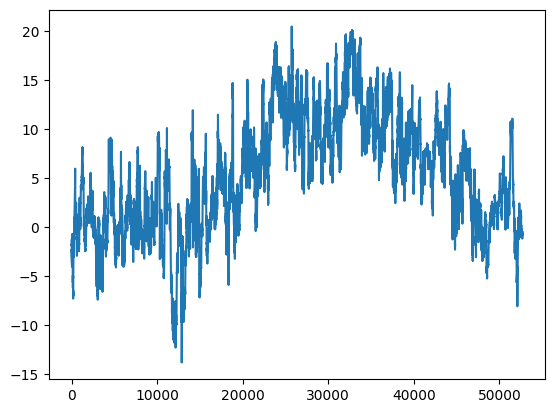

In [53]:
plt.plot(data[:,4].astype("float32")[:])